# Colab データインストール

In [0]:
# 以下を実行すると、認証情報を取得するための許可を求められるので、許可してトークンを発行し、テキストボックスに貼り付ける。
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()

In [2]:
# Colabにおいてデータを読みこむ。グーグルドライブをマウントします。その為に必要なパッケージを取得しておく。
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse


gpg: keybox '/tmp/tmpyk7g_ymo/pubring.gpg' created
gpg: /tmp/tmpyk7g_ymo/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1


In [3]:
# 以下実行により、今度は google-drive-ocamlfuse によるアクセスの許可を聞かれる。これも許可する。
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

··········


In [4]:
# 今回は指定したフォルダのみマウントする
!cp -f ~/.gdfuse/default/config config
!sed -i -e "s/^root_folder=$/root_folder=1FwGdPnKlcYYRe1mZGE5Ci-PWlIY8k5J7/" config
# 上記が正常に終われば、ようやくマウントが可能となる。
!mkdir -p drive
!google-drive-ocamlfuse -config ./config -cc drive
!ls drive

Clearing cache...done
fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option
8_3-4			    dataset				  week3-EDA
8_5-6			    Kaggle_0				  week4
compare-deeplibs.ipynb	    Santander_Value_Prediction_Challenge
dataマウントテンプレ.ipynb  test.ipynb


In [5]:
# これ以降はターミナルと同様にディレクトリを扱える
cd drive/dataset

/content/drive/dataset


In [6]:
ls

Home Credit Default Risk/  Mercedes-Benz Greener Manufacturing/
House Prices_data/         Porto Seguro’s Safe Driver Prediction/
Instacart Market Basket/   Titanic/


In [7]:
cd Home Credit Default Risk

/content/drive/dataset/Home Credit Default Risk


In [0]:
ls

application_test.csv                           installments_payments.csv
application_train.csv                          POS_CASH_balance.csv
bureau_balance.csv                             previous_application.csv
bureau.csv                                     sample_submission.csv
credit_card_balance.csv                        submission2.csv
HomeCredit_columns_description.csv             submission3.csv
HomeCredit_columns_description.ods             submission.csv
HomeCredit_columns_description.ods (7efe7569)  train_profile.html


# Home Credit Default Risk Competition

## Imports

In [0]:
# pandas and numpy for data manipulation
import numpy as np
import pandas as pd 

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [0]:
# pandasのデータの表示
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_row', 20)

## Read in Data 

In [17]:
train = pd.read_csv("application_train.csv")
test = pd.read_csv("application_test.csv")
print("Train rows and columns : ", train.shape)
print("Test rows and columns : ", test.shape)

Train rows and columns :  (307511, 122)
Test rows and columns :  (48744, 121)


In [18]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Missing data

In [0]:
# データの処理を行うにあたって、trainデータとtestデータを結合する
total_data = pd.concat([train, test], join='inner')

# innerにすることで、TARGETカラムを含まず結合されている

In [20]:
total_data.shape

(356255, 121)

In [21]:
def Drop_nan(Data):
     
     # 自動車を所有していない人は、"OWN_CAR_AGE"がnanになっているので、0で埋める。
    Data["OWN_CAR_AGE"]=Data["OWN_CAR_AGE"].fillna(0)
    
    
    #  欠損が20000以上ある特徴量は削除することにする。
    total_anynull_df_dropNull  =  Data.dropna(thresh=200000,axis=1)
    total_anynull_df_dropNull.shape,    Data.shape
    pd.DataFrame(total_anynull_df_dropNull.isnull().sum().sort_values(ascending=False))
    
    
    # "OCCUPATION_TYPE"の欠損の穴埋め。nanのところは"No workとして穴埋め。"
    total_anynull_df_dropNull["OCCUPATION_TYPE"].unique()
    total_anynull_df_dropNull["OCCUPATION_TYPE"]=total_anynull_df_dropNull["OCCUPATION_TYPE"].fillna("No work")
    
    #  "CNT_FAM_MEMBERS"の欠損の穴埋め。nanは中央値で穴埋め。
    total_anynull_df_dropNull["CNT_FAM_MEMBERS"]=total_anynull_df_dropNull["CNT_FAM_MEMBERS"] .fillna(total_anynull_df_dropNull["CNT_FAM_MEMBERS"].median())
    total_anynull_df_dropNull["CNT_FAM_MEMBERS"].isnull().any()
    
    
    #  "DAYS_LAST_PHONE_CHANGE"の欠損の穴埋め。nanは中央値で穴埋め。
    total_anynull_df_dropNull["DAYS_LAST_PHONE_CHANGE"]=total_anynull_df_dropNull["DAYS_LAST_PHONE_CHANGE"] .fillna(total_anynull_df_dropNull["DAYS_LAST_PHONE_CHANGE"].median())
    total_anynull_df_dropNull["DAYS_LAST_PHONE_CHANGE"].isnull().any()
    
    
    #  "NAME_TYPE_SUITE"の欠損の穴埋め。nanは"Unaccompanied"で穴埋め。
    total_anynull_df_dropNull["NAME_TYPE_SUITE"]=total_anynull_df_dropNull["NAME_TYPE_SUITE"].fillna("Unaccompanied")
    total_anynull_df_dropNull["NAME_TYPE_SUITE"].isnull().any()
    
    #残りの欠損値の確認
    pd.DataFrame(total_anynull_df_dropNull.isnull().sum().sort_values(ascending=False))
    
    #total_anynull_df_dropNull
    
    
    # 欠損値のある特徴量をリストにする。
    Null_list=list(total_anynull_df_dropNull.loc[ :,total_anynull_df_dropNull.isnull().any() ].columns)
    
    #Null_list
    
    
    #  残りの欠損値については、各特徴量の平均で穴埋め。
    for i in Null_list:
        total_anynull_df_dropNull[i] = total_anynull_df_dropNull[i].fillna(total_anynull_df_dropNull[i].mean())
    
    
    #  欠損が取り除けたかどうか確認。Falseが返ってくれば問題なし。
    return pd.DataFrame(total_anynull_df_dropNull)
  
total_data = Drop_nan(total_data)
print(total_data.isnull().any().any())

False


## Categorical variables

In [22]:
# Label_encoder
def Label_encode(Data):
    le = LabelEncoder()
    le_count = 0

    for col in list(Data.columns):
        if Data[col].dtype == 'object':
            if len(list(Data[col].unique())) <= 2:
                le.fit(Data[col])

                Data[col] = le.transform(Data[col])

                #何を いくつ変換したか記録する
                print(col)
                le_count += 1
            
    return  Data
  
  
# One-Hot Encoder
def One_hot_Encode(Data):
    Data = pd.get_dummies(Data)
    return Data

total_data = Label_encode(total_data)
total_data = One_hot_Encode(total_data)

NAME_CONTRACT_TYPE
FLAG_OWN_CAR
FLAG_OWN_REALTY


## 外れ値を除く

EDAをして情報収集すると'DAYS_EMPLOYED'に外れ値が含まれていることがわかります。  

In [23]:
# 勤務日数が1000年ということになっている(=異常値)
total_data['DAYS_EMPLOYED'].describe()

count    356255.000000
mean      64317.231413
std      141705.532576
min      -17912.000000
25%       -2781.000000
50%       -1224.000000
75%        -290.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

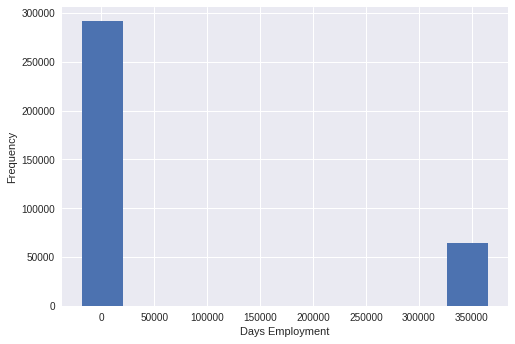

In [24]:
# グラフでも確認して見る
total_data['DAYS_EMPLOYED'].plot.hist();
plt.xlabel('Days Employment');

In [0]:
err = total_data[total_data['DAYS_EMPLOYED'] == 365243]
not_err = total_data[total_data['DAYS_EMPLOYED'] != 365243]

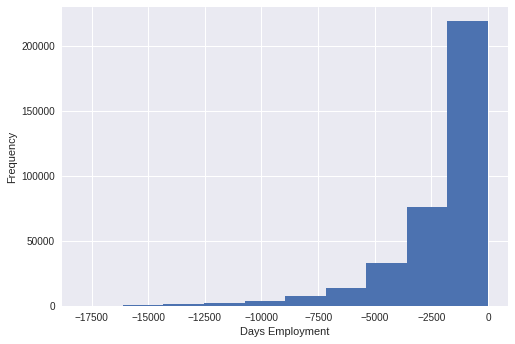

In [26]:
# Create an err flag column
total_data['DAYS_EMPLOYED_err'] = total_data["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
total_data['DAYS_EMPLOYED'].replace({365243: 0}, inplace = True)

# グラフで消えたのを確認する
total_data['DAYS_EMPLOYED'].plot.hist();
plt.xlabel('Days Employment');

## Modeling

! 未実装
モデルがうまく走るか少数のデータで実行して検証。

In [0]:
# total_dataの中にあるtestデータ分をrecoverする
X_train = total_data.iloc[:307511, :]

In [0]:
# Split Data

# trainデータを目的変数と説明変数に分ける
from sklearn.model_selection import train_test_split

y = train['TARGET']
X = X_train

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


### LightGBM

In [19]:
!pip install lightgbm

In [0]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

from sklearn.model_selection import KFold, cross_val_score

# LGBMのパラメータの設定
lgm_params = {
          'objective' : 'binary',
          'boosting_type': 'gbdt',
          'metric' : 'auc',
          'nthread' : 4,
          'shrinkage_rate':0.01,
          'max_depth':18,
          'min_child_weight': 2,
          'bagging_fraction':0.65,
          'feature_fraction':0.8,
          'lambda_l1':1,
          'lambda_l2':1,
          'num_leaves':35}        

# LGBMのモデルの作成
lgbm_model = lgb.train(lgm_params, lgb.Dataset(X_train, y_train), 3000, 
                       [lgb.Dataset(X_train, y_train), lgb.Dataset(X_test, y_test)], verbose_eval=10, early_stopping_rounds=20)

# 記録　[1139]	valid_0's auc: 0.794641	valid_1's auc: 0.754739

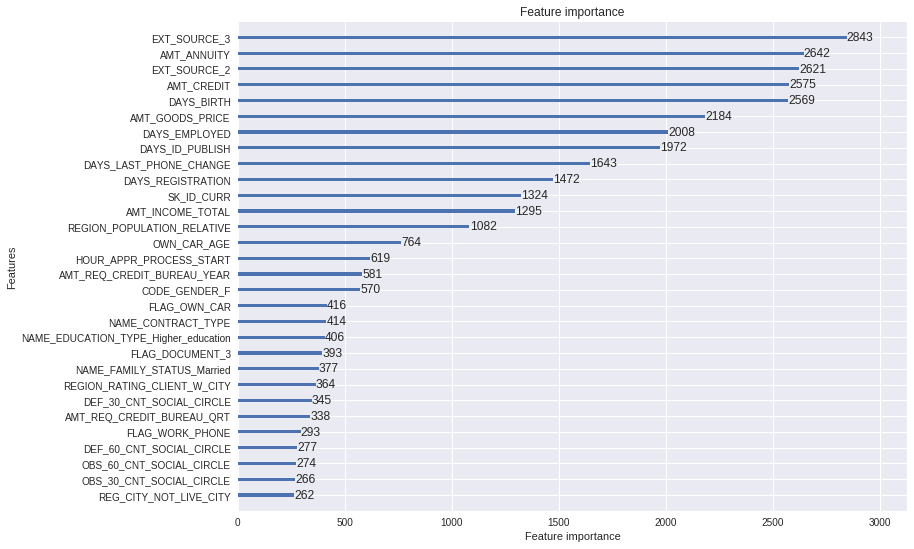

In [26]:
lgb.plot_importance(lgbm_model, max_num_features=30, figsize=(12, 9))

## Submission

In [0]:
# testデータの整形されたものを抽出
Y_totaltest = total_data.iloc[307511:, :]

In [0]:
# sklearnのpredictでデータを予測
rezult = lgbm_model.predict(Y_totaltest)

In [101]:
rezult

array([0.05780003, 0.20068403, 0.01827068, ..., 0.06516114, 0.06786343,
       0.15477103])

In [102]:
# 形を確認
rezult.shape

(48744,)

In [0]:
# サンプルを確認する
submission = pd.read_csv("sample_submission.csv")

In [0]:
# サンプルの形と自分のものが一致しているか確認
submission

In [0]:
# IDを付与する
submission.iloc[:, 1] = rezult
submission

In [0]:
# カレントディレクトリにcsvを保存
submission.to_csv('submission3.csv', index= False)

# Note section (EDA)

 !! ここはメモ記録を含んでいます  

## Missing data

In [27]:
# 欠損値を含むカラムを抽出
anynull_df=train.loc[:,train.isnull().any()]
anynull_df

,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,OWN_CAR_AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,24700.5,351000.0,Unaccompanied,NaN,Laborers,1.0,0.083037,0.262949,0.139376,0.0247,...,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0
1,35698.5,1129500.0,Family,NaN,Core staff,2.0,0.311267,0.622246,NaN,0.0959,...,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6750.0,135000.0,Unaccompanied,26.0,Laborers,1.0,NaN,0.555912,0.729567,NaN,...,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0
3,29686.5,297000.0,Unaccompanied,NaN,Laborers,2.0,NaN,0.650442,NaN,NaN,...,0.0,2.0,0.0,-617.0,NaN,NaN,NaN,NaN,NaN,NaN
4,21865.5,513000.0,Unaccompanied,NaN,Core staff,1.0,NaN,0.322738,NaN,NaN,...,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0
5,27517.5,454500.0,"Spouse, partner",NaN,Laborers,2.0,NaN,0.354225,0.621226,NaN,...,0.0,0.0,0.0,-2536.0,0.0,0.0,0.0,0.0,1.0,1.0
6,41301.0,1395000.0,Unaccompanied,17.0,Accountants,3.0,0.774761,0.724000,0.492060,NaN,...,0.0,1.0,0.0,-1562.0,0.0,0.0,0.0,1.0,1.0,2.0
7,42075.0,1530000.0,Unaccompanied,8.0,Managers,2.0,NaN,0.714279,0.540654,NaN,...,0.0,2.0,0.0,-1070.0,0.0,0.0,0.0,0.0,0.0,0.0
8,33826.5,913500.0,Children,NaN,NaN,2.0,0.587334,0.205747,0.751724,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,20250.0,405000.0,Unaccompanied,NaN,Laborers,1.0,NaN,0.746644,NaN,NaN,...,0.0,2.0,0.0,-1673.0,NaN,NaN,NaN,NaN,NaN,NaN


欠損を含むカラムだけを表示させてそれぞれの意味を確認しどのように処理するか検討

In [28]:
pd.DataFrame(anynull_df.columns)

,0
0,AMT_ANNUITY
1,AMT_GOODS_PRICE
2,NAME_TYPE_SUITE
3,OWN_CAR_AGE
4,OCCUPATION_TYPE
5,CNT_FAM_MEMBERS
6,EXT_SOURCE_1
7,EXT_SOURCE_2
8,EXT_SOURCE_3
9,APARTMENTS_AVG


In [29]:
# 欠損値が多い順に並べる
total_null = train.isnull().sum().sort_values()[::-1]
total_null[:15]

COMMONAREA_MEDI             214865
COMMONAREA_AVG              214865
COMMONAREA_MODE             214865
NONLIVINGAPARTMENTS_MODE    213514
NONLIVINGAPARTMENTS_MEDI    213514
NONLIVINGAPARTMENTS_AVG     213514
FONDKAPREMONT_MODE          210295
LIVINGAPARTMENTS_MEDI       210199
LIVINGAPARTMENTS_MODE       210199
LIVINGAPARTMENTS_AVG        210199
FLOORSMIN_MEDI              208642
FLOORSMIN_MODE              208642
FLOORSMIN_AVG               208642
YEARS_BUILD_MEDI            204488
YEARS_BUILD_AVG             204488
dtype: int64

In [30]:
# 割合で確認(全てのカラムを表示)
percent = (train.isnull().sum()/train.isnull().count()*100).sort_values()[::-1]
missing_train_data  = pd.concat([total_null, percent], axis=1, keys=['total_null', 'Percent'])
missing_train_data

,total_null,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953


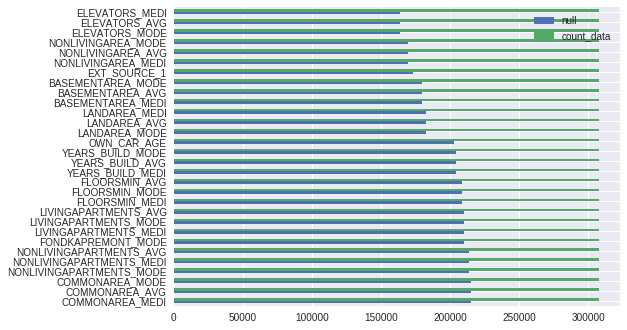

In [31]:
# 欠損の割合をグラフ化
null = train.isnull().sum()
count_data = train.isnull().count()

null_train_data  = pd.concat([null, count_data], axis=1, keys=['null', 'count_data']).sort_values(by=['null'])[::-1]
plt.figure(figsize=(12,5))
null_train_data[:30].plot.barh()

### 欠損値の種類

ここで欠損値の種類について一般論を確認しておく。

欠損値には以下のように、大きく分けて3種類ある。(Little and Rubin, 2002, pp.11-12,　pp.312-313)。

- Missing Completely At Random (MCAR):完全にランダムな欠損。

- Missing At Random (MAR):別の変数に依存して発生している欠損

- Missing Not At Random (MNAR):その変数自体に原因がある場合。


それぞれに応じて欠損値の処理方法もいろいろあるようだが、完全情報最尤推定法もしくは多重代入法と呼ばれる方法であれば、もとの情報を損失せずに補完できるようである。

その他に、欠損が上記分類のどれに該当するのかを統計処理で確認する方法や、欠損の種類に対する処理の仕方がどのくらい影響するのかといった部分なども確認する必要がある。

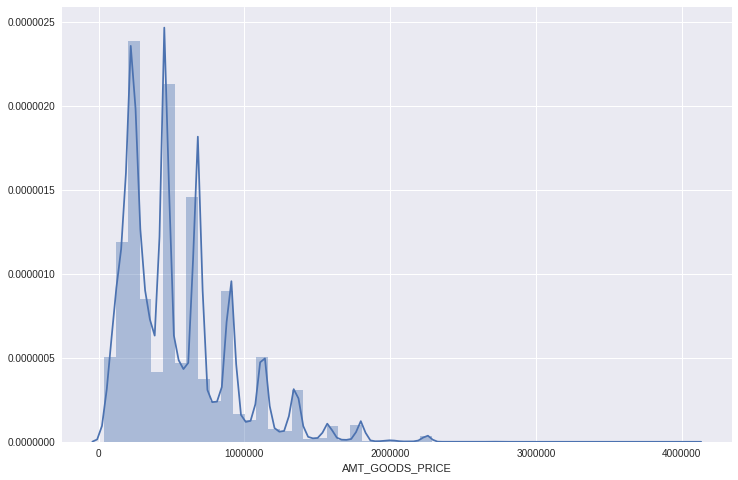

In [32]:
plt.figure(figsize=(12,8))
sns.distplot(train["AMT_GOODS_PRICE"].dropna())

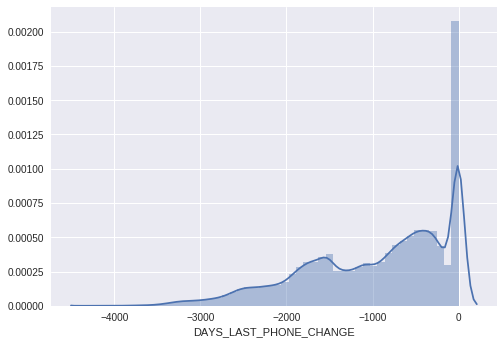

In [33]:
sns.distplot(train["DAYS_LAST_PHONE_CHANGE"].dropna())

In [0]:
# データの処理を行うにあたって、trainデータとtestデータを結合する
total_data = pd.concat([train, test], join='inner')

In [35]:
total_data.shape

(356255, 121)

In [0]:
# 欠損処理
total_data["OWN_CAR_AGE"]=total_data["OWN_CAR_AGE"].fillna(0)

total_data["OCCUPATION_TYPE"].unique()
total_data["OCCUPATION_TYPE"]=total_data["OCCUPATION_TYPE"].fillna("No work")

total_data["CNT_FAM_MEMBERS"]=total_data["CNT_FAM_MEMBERS"].fillna(total_data["CNT_FAM_MEMBERS"].median())
# total_data["CNT_FAM_MEMBERS"].isnull().any()

total_data["DAYS_LAST_PHONE_CHANGE"]=total_data["DAYS_LAST_PHONE_CHANGE"].fillna(total_data["DAYS_LAST_PHONE_CHANGE"].median())
# total_data["DAYS_LAST_PHONE_CHANGE"].isnull().any()


In [37]:
# 欠損の多すぎるカラムはドロップすることにする
total_anynull_df_dropNull = total_data.dropna(thresh=200000,axis=1)

pd.DataFrame(total_anynull_df_dropNull.isnull().sum().sort_values(ascending=False))

,0
EXT_SOURCE_3,69633
AMT_REQ_CREDIT_BUREAU_YEAR,47568
AMT_REQ_CREDIT_BUREAU_MON,47568
AMT_REQ_CREDIT_BUREAU_WEEK,47568
AMT_REQ_CREDIT_BUREAU_DAY,47568
AMT_REQ_CREDIT_BUREAU_HOUR,47568
AMT_REQ_CREDIT_BUREAU_QRT,47568
NAME_TYPE_SUITE,2203
DEF_60_CNT_SOCIAL_CIRCLE,1050
OBS_60_CNT_SOCIAL_CIRCLE,1050


In [38]:
# データに欠損値がある(True)ない(False)を返す最終チェック
total_data.isnull().any().any()

True

## categorical variables

どの特徴がカテゴリ変数なのか確認

In [39]:
total_data.dtypes

SK_ID_CURR                      int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
FLAG_OWN_REALTY                object
CNT_CHILDREN                    int64
AMT_INCOME_TOTAL              float64
AMT_CREDIT                    float64
AMT_ANNUITY                   float64
AMT_GOODS_PRICE               float64
                               ...   
FLAG_DOCUMENT_18                int64
FLAG_DOCUMENT_19                int64
FLAG_DOCUMENT_20                int64
FLAG_DOCUMENT_21                int64
AMT_REQ_CREDIT_BUREAU_HOUR    float64
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 121, dtype: object

In [40]:
# カテゴリー変数の数を確認
total_data.dtypes.value_counts()

float64    65
int64      40
object     16
dtype: int64

グラフ化

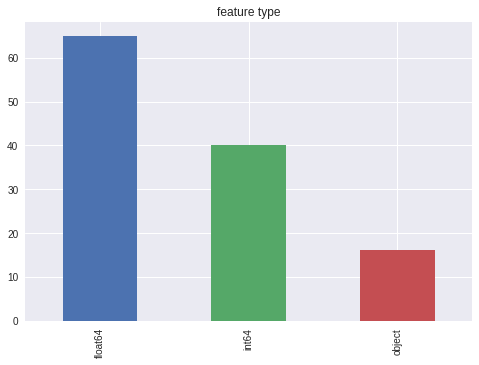

float64    65
int64      40
object     16
dtype: int64

In [41]:
total_data.dtypes.value_counts().plot.bar()
plt.title("feature type")
plt.show()

total_data.dtypes.value_counts()

In [42]:
# データフレームのタイプを指定して抽出
train_objectlist=total_data.select_dtypes(include=['object'])
train_objectlist

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,reg oper account,block of flats,"Stone, brick",No
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School,reg oper account,block of flats,Block,No
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,NaN,NaN,NaN,NaN
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,NaN,NaN,NaN,NaN
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion,NaN,NaN,NaN,NaN
5,Cash loans,M,N,Y,"Spouse, partner",State servant,Secondary / secondary special,Married,House / apartment,Laborers,WEDNESDAY,Other,NaN,NaN,NaN,NaN
6,Cash loans,F,Y,Y,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,Accountants,SUNDAY,Business Entity Type 3,NaN,NaN,NaN,NaN
7,Cash loans,M,Y,Y,Unaccompanied,State servant,Higher education,Married,House / apartment,Managers,MONDAY,Other,NaN,NaN,NaN,NaN
8,Cash loans,F,N,Y,Children,Pensioner,Secondary / secondary special,Married,House / apartment,No work,WEDNESDAY,XNA,NaN,NaN,NaN,NaN
9,Revolving loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,THURSDAY,Electricity,NaN,NaN,NaN,NaN


### コード

In [43]:
# One-Hot Encoder
total_data = pd.get_dummies(total_data)

print('total_data Features shape: ', total_data.shape)

total_data Features shape:  (356255, 246)


In [44]:
total_data.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,...,0,0,0,0,0,0,1,0,1,0
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,...,0,1,0,0,0,0,0,0,1,0
2,100004,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,...,0,0,0,0,0,0,0,0,0,0


トレーニングデータとテストデータの両方に同じ機能（列）が必要なので、整形します。  
この時、列に基づいてデータフレームを整列させるためにaxis = 1を設定する

In [45]:
'''
不要になったので備忘録

# trainのTARGETカラムは唯一の変数で消えては困るので抽出
train_labels = train['TARGET']

# トレーニングとテストのデータを整列させ、両方のデータフレームに存在する列のみを維持する(join = 'inner')
train, test = train.align(test, join = 'inner', axis = 1)

# ターゲットを戻す
train['TARGET'] = train_labels

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

'''

"\n不要になったので備忘録\n\n# trainのTARGETカラムは唯一の変数で消えては困るので抽出\ntrain_labels = train['TARGET']\n\n# トレーニングとテストのデータを整列させ、両方のデータフレームに存在する列のみを維持する(join = 'inner')\ntrain, test = train.align(test, join = 'inner', axis = 1)\n\n# ターゲットを戻す\ntrain['TARGET'] = train_labels\n\nprint('Training Features shape: ', train.shape)\nprint('Testing Features shape: ', test.shape)\n\n"

In [46]:
total_data.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('uint8')], dtype=object)

In [47]:
print('total_data: ', total_data.shape)

total_data:  (356255, 246)


ラベルエンコーダーを使う前を確認  
'NAME_CONTRACT_TYPEを例に確認する

In [0]:
total_data['NAME_CONTRACT_TYPE'].unique()

In [0]:
# ラベルエンコーダー

# label encoder のオブジェクトを生成する
le = LabelEncoder()
le_count = 0

for col in total_data:
    if total_data[col].dtype == 'object':
        if len(list(total_data[col].unique())) <= 2:
            le.fit(total_data[col])
            
            total_data[col] = le.transform(total_data[col])
            test[col] = le.transform(test[col])
            
            #何を いくつ変換したか記録する
            print(col)
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

NAME_CONTRACT_TYPE
FLAG_OWN_CAR
FLAG_OWN_REALTY
3 columns were label encoded.


エンコーダー使った後を確認

In [0]:
total_data['NAME_CONTRACT_TYPE'].unique()

array([0, 1])

その他のカテゴリー変数の確認  
変化の差を見ておく

In [0]:
total_data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,0,M,0,1,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
1,100003,0,F,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,100004,1,M,1,1,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,100006,0,F,0,1,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0.005808,0.006281,0.029995,0.231697,0.304399,1.911564
4,100007,0,M,0,1,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
